# AnimalTrackID

The benefits of wildlife tracking underscore its importance in wildlife conservation—it unpacks information relating not only to species identification and recognition but also to population dynamics, migration patterns, habitat use, and the effects of environmental changes. Most traditional wildlife tracking methods, such as collaring, banding, and GPS tracking, are invasive methods that require physical interaction with wildlife, potentially causing stress or disrupting its natural behavior. In addition, these methods are expensive and logistically challenging. However, the impressions left by the foot of terrestrial animals provide a noninvasive alternative to traditional wildlife tracking methods. Despite its potential, building machine learning models for wildlife tracking remains a daunting challenge due to the absence of a comprehensive and well-labeled dataset. This leaves researchers and conservationists without a scalable, cost-effective tool for tracking wildlife.

In [1]:
# import all modules

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import L2
from sklearn.metrics import classification_report, accuracy_score

2025-02-18 14:26:28.491685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Dataset

The dataset used below is an augmented and resized to 240 * 240 version of Risa's Dataset. The code for this is found on the 'Stage' branch of the project's GitHub repository (https://github.com/kayc0des/AnimalTrackID)

- `dataprep.py`: Loads the data folder and resizes the images to 240 * 240
- `datagen.py`: An augmentation class augments data in different folders according to a defined rule created to handle class imbalances.

In [2]:
train = np.load('npz/train_data.npz')
test = np.load('npz/test_data.npz')
val = np.load('npz/val_data.npz')

# Assigning data to X=input, Y=label
X_train, Y_train = train['X'], train['Y']
X_test, Y_test = test['X'], test['Y']
X_val, Y_val = val['X'], val['Y']

## Plot 10 Data Samples

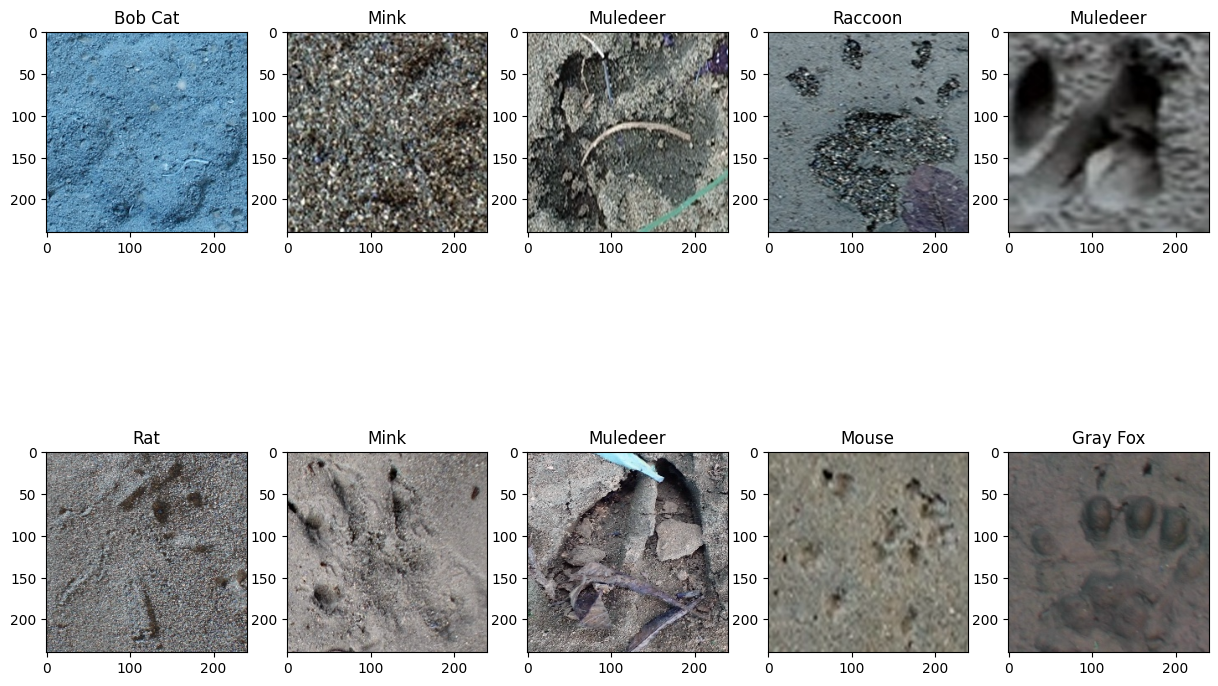

In [3]:
# Plot 10 random data samples from X and their equivalent Y value as subplot label

fig, ax = plt.subplots(2, 5, figsize=(15, 10))
for i in range(10):
    idx = np.random.randint(0, X_train.shape[0])
    ax[i//5, i%5].imshow(X_train[idx])
    ax[i//5, i%5].set_title(Y_train[idx])
plt.show()

## Data Preprocessing Pipeline

This class provides a preprocessing pipeline for footprint images. It allows for the application of grayscale conversion, Canny edge detection, and Gabor filtering. You can selectively enable these transformations when instantiating the class. (Credits: )

### Features:
- **Grayscale Conversion**: Converts images to grayscale to reduce complexity.
- **Canny Edge Detection**: Highlights edges in the images to capture footprint contours.
- **Gabor Filtering**: Extracts texture features from the footprints for better classification.
- **Customizable Parameters**: Users can specify Gabor filter parameters such as kernel size, sigma, theta, and more.
- **Dataset Preprocessing**: Loads and preprocesses an entire dataset stored in `.npz` format.

In [6]:
class FootprintProcessor:
    """ This Class handles footprint image processing """

    def __init__(self, grayscale=False, normalize=False, canny=False, gabor=False, ksize=5, sigma=0.1, theta=np.pi/4, lambd=10, gamma=0.5, psi=0, ktype=cv2.CV_32F, plotSamples=False):
        """ Initialize the FootprintProcessor

        Param:
            grayscale (bool, optional): Whether to convert the image to grayscale. Defaults to False.
            canny (bool, optional): Whether to apply Canny edge detection. Defaults to False.
            gabor (bool, optional): Whether to apply Gabor filter. Defaults to False.
            ksize (int, optional): Kernel size for Gabor filter. Defaults to 5.
            sigma (float, optional): Sigma value for Gabor filter. Defaults to 0.1.
            theta (float, optional): Theta value for Gabor filter. Defaults to np.pi/4.
            lambd (int, optional): Lambda value for Gabor filter. Defaults to 10.
            gamma (float, optional): Gamma value for Gabor filter. Defaults to 0.5.
            psi (float, optional): Psi value for Gabor filter. Defaults to 0.
            ktype (int, optional): Type of kernel for Gabor filter. Defaults to cv2.CV_32F.
        """

        self.grayscale = grayscale
        self.normalize = normalize
        self.canny = canny
        self.gabor = gabor
        self.ksize = ksize
        self.sigma = sigma
        self.theta = theta
        self.lambd = lambd
        self.gamma = gamma
        self.psi = psi
        self.ktype = ktype
        self.plotSamples = plotSamples

    def apply_grayscale(self, image):
        """ Convert the image to grayscale

        Param:
            image (numpy.ndarray): The input image.

        Returns:
            numpy.ndarray: The grayscale image.
        """
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    def apply_normalize(self, image):
        """ Normalize the image by dividing by 255.0

        Param:
            image (numpy.ndarray): The input image.

        Returns:
            numpy.ndarray: The normalized image.
        """
        return image / 255.0

    def apply_canny(self, image):
        """ Apply Canny edge detection

        Param:
            image (numpy.ndarray): The input image.

        Returns:
            numpy.ndarray: The Canny edge image.
        """
        image = image.astype(np.uint8)
        return cv2.Canny(image, 100, 200)

    def apply_gabor(self, image):
        """ Apply Gabor filter

        Param:
            image (numpy.ndarray): The input image.

        Returns:
            numpy.ndarray: The Gabor filtered image.
        """
        kernel = cv2.getGaborKernel((self.ksize, self.ksize), self.sigma, self.theta, self.lambd, self.gamma, self.psi, self.ktype)
        return cv2.filter2D(image, cv2.CV_8U, kernel)

    def preprocess(self, image):
        """ Preprocess the image

        Param:
            image (numpy.ndarray): The input image.

        Returns:
            numpy.ndarray: The preprocessed image.
        """
        if self.grayscale:
            image = self.apply_grayscale(image)
        if self.normalize:
            image = self.apply_normalize(image)
        if self.canny:
            image = self.apply_canny(image)
        if self.gabor:
            image = self.apply_gabor(image)
        return image

    def process_dataset(self, dataset_path):
        """ Process the dataset

        Param:
            dataset_path (str): The path to the dataset.

        Returns:
            tuple: A tuple containing the processed images and labels.
        """

        try:
            data = np.load(dataset_path)
        except FileNotFoundError:
            print(f"Dataset not found at {dataset_path}")
            return None
        except Exception as e:
            print(f"Error loading dataset: {e}")
            return None

        if 'X' not in data or 'Y' not in data:
            print("Dataset does not contain 'X' or 'Y' keys")
            return None

        images, self.labels = data['X'], data['Y']

        if len(images) != len(self.labels):
            print("Number of images and labels do not match")
            return None

        self.processed_images = np.array([self.preprocess(image) for image in images])

        if self.plotSamples:
            self.plot_samples()

        return self.processed_images, self.labels

    def plot_samples(self):
        """ Plot 10 random samples from the dataset """
        fig, ax = plt.subplots(2, 5, figsize=(15, 10))
        for i in range(10):
            idx = np.random.randint(0, self.processed_images.shape[0])
            ax[i//5, i%5].imshow(self.processed_images[idx], cmap='gray')
            ax[i//5, i%5].set_title(self.labels[idx])
        plt.show()

## Grayscale Only

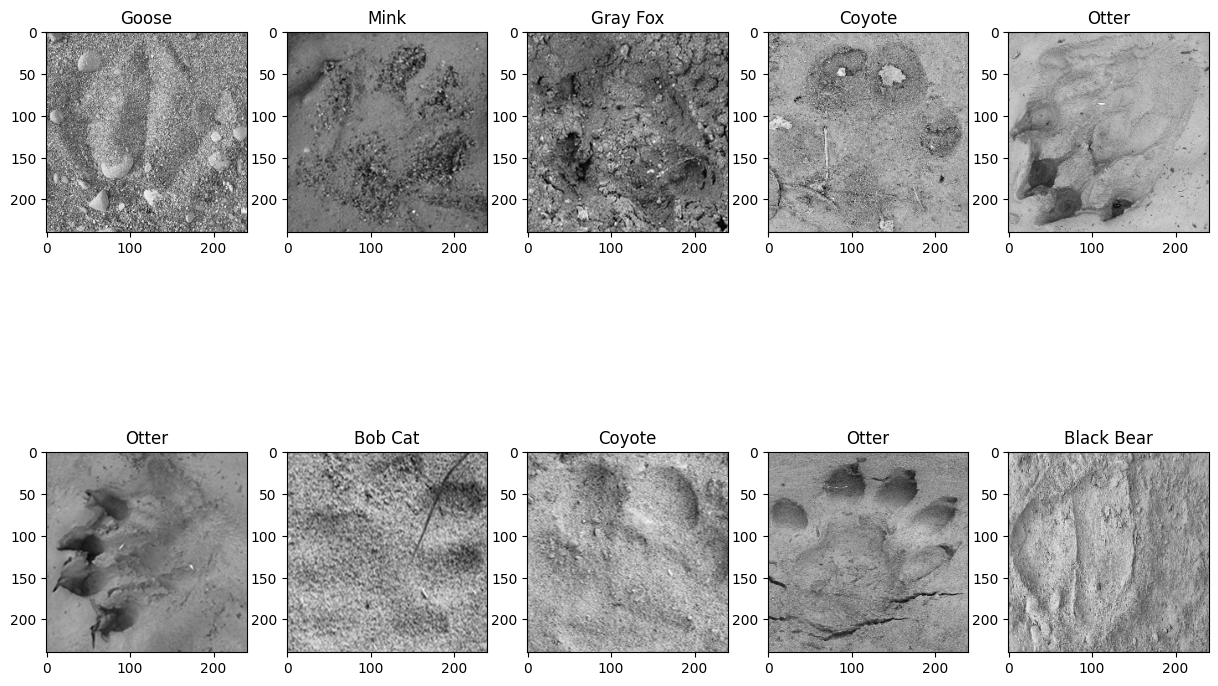

In [10]:
preprocessorX = FootprintProcessor(grayscale=True, normalize=False, canny=False, gabor=True, plotSamples=True)
X_train_normX, Y_train_normX = preprocessorX.process_dataset('npz/train_data.npz')

In [8]:
np.shape(X_train_normX[0])

(240, 240)

## Grayscale + Canny + Gabor

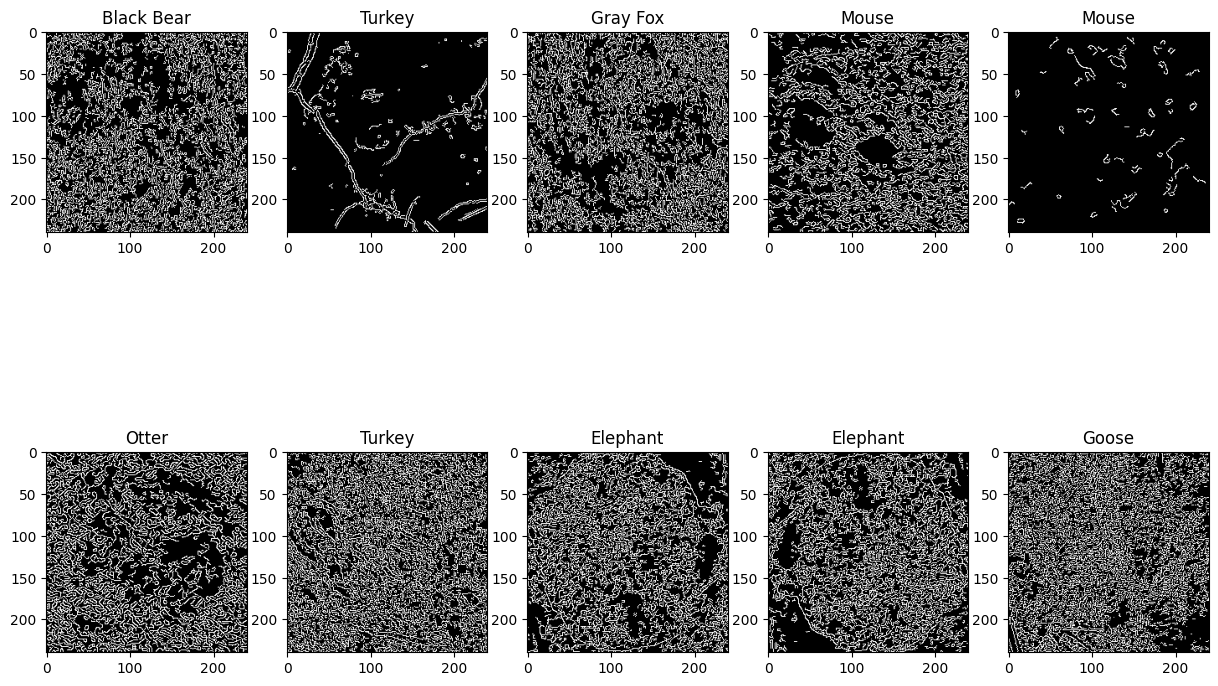

In [9]:
preprocessor = FootprintProcessor(grayscale=True, normalize=False, canny=True, gabor=True, plotSamples=True)
X_train_gc, Y_train_gc = preprocessor.process_dataset('npz/train_data.npz')

Creates a distorted representation of the image, worth exploring if this could help in model training.

## Using Grayscale images and a simple CNN Structure

In [15]:
# Load and Run data via the preprocessor

footprintPreprocessor = FootprintProcessor(grayscale=False, normalize=True, canny=False, gabor=False, plotSamples=False)
X_Train, Y_Train = footprintPreprocessor.process_dataset('npz/train_data.npz')
X_Test, Y_Test = footprintPreprocessor.process_dataset('npz/test_data.npz')
X_Val, Y_Val = footprintPreprocessor.process_dataset('npz/val_data.npz')

label_encoder = LabelEncoder()
Y_Train = label_encoder.fit_transform(Y_Train)
Y_Test = label_encoder.transform(Y_Test)
Y_Val = label_encoder.transform(Y_Val)

# to categorical
Y_Train = to_categorical(Y_Train)
Y_Test = to_categorical(Y_Test)
Y_Val = to_categorical(Y_Val)

In [16]:
Y_Train[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0.])

In [20]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(240, 240, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    
    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(18, activation='softmax')
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [21]:
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_Train, Y_Train, batch_size=32,
    validation_data=(X_Val, Y_Val),
    epochs=20,
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(X_Test, Y_Test)
print(f"Test Accuracy: {test_acc:.4f}")

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Performance")

Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 125s 897ms/step - accuracy: 0.0667 - loss: 3.0007 - val_accuracy: 0.1185 - val_loss: 2.8776 - learning_rate: 0.0010
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 110s 830ms/step - accuracy: 0.0804 - loss: 2.8723 - val_accuracy: 0.1503 - val_loss: 2.8141 - learning_rate: 0.0010
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 124s 932ms/step - accuracy: 0.0933 - loss: 2.8342 - val_accuracy: 0.1156 - val_loss: 2.7668 - learning_rate: 0.0010
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.0957 - loss: 2.8411 - val_accuracy: 0.1272 - val_loss: 2.7668 - learning_rate: 0.0010
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 121s 904ms/step - accuracy: 0.1027 - loss: 2.8260 - val_accuracy: 0.1416 - val_loss: 2.7390 - learning_rate: 0.0010
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.1080 - loss: 2.8092 - val_accuracy: 0.1474 - val_loss: 2.7593 - learning_rate: 0.0010
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.095

KeyboardInterrupt: 

## Compute Class Weights and Use in Training